# Классификация текстов наивным бейсовским методом

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Датасет

Будем классифицировать тексты из датасета [20 newsgroups](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset) из `scikit-learn`.

In [2]:
training_corpus = fetch_20newsgroups(subset="train")

In [3]:
print(f"Размер обучающей выборки: {len(training_corpus.data)}")

Размер обучающей выборки: 11314


In [4]:
print("Классы текстов:")
training_corpus.target_names

Классы текстов:


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
print("Метки текстов:")
training_corpus.target

Метки текстов:


array([7, 4, 4, ..., 3, 1, 8])

In [6]:
type(training_corpus.data)

list

Посмотрим на первый пост

In [7]:
print(training_corpus.data[0])

first_doc_label = training_corpus.target[0]
print(f"Метка: {first_doc_label}")
print(f"Класс: {training_corpus.target_names[first_doc_label]}")

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Метка: 7
Класс: rec.autos


Посмотрим на распределение классов

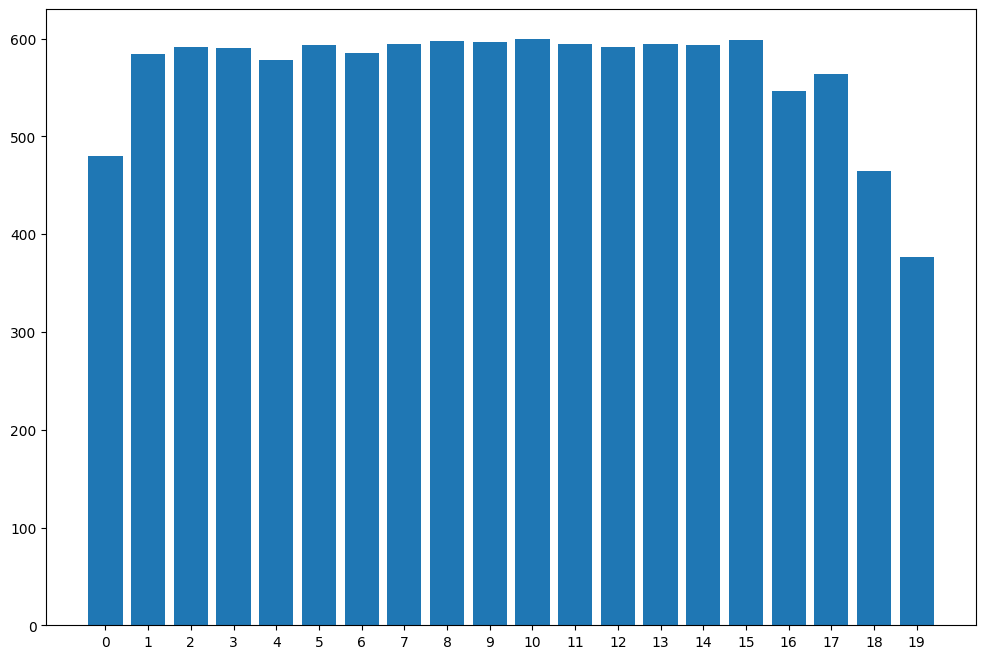

In [8]:
bins, counts = np.unique(training_corpus.target, return_counts=True)
plt.figure(figsize=(12, 8))
plt.bar(bins, counts)
plt.xticks(bins)
plt.show()

## Train-Validation split

Разделим выборку на тренировочную и валидационную. Тестовая выборка мы получим позже.

In [9]:
train_data, val_data, train_labels, val_labels = train_test_split(
    training_corpus.data,
    training_corpus.target,
    train_size=0.8,
    random_state=1,
)
print(f"Размер обучающей выборки {len(train_data)}")
print(f"Размер валидационной выборки {len(val_data)}")

Размер обучающей выборки 9051
Размер валидационной выборки 2263


## Токенизация и векторизация

- Будем использовать токенизатор от `spacy`;
- векторизировать будем с `tfidf` методом.

In [10]:
nlp = spacy.blank("en")

In [11]:
def spacy_tokenizer(string: str):
    return [t.text for t in nlp(string) if t.is_alpha]

In [12]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, token_pattern=None)

In [13]:
vectorizer.fit(train_data)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function spa...x74338ed6a7a0>
,analyzer,'word'
,stop_words,None
,token_pattern,None
,ngram_range,"(1, ...)"


## Обучение модели

Для классификации текстов используют `MultinomialNB`, предназначенный для дискретных данных. Признаками могут является количество вхождений слова (Count Vectorizer) или его вес (TF-IDF Vectorizer).

In [14]:
X_train = vectorizer.transform(train_data)
X_val = vectorizer.transform(val_data)

In [15]:
nb_classifier = MultinomialNB()

In [16]:
nb_classifier.fit(X_train, train_labels)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [17]:
train_preds = nb_classifier.predict(X_train)
print(
    f"F1-score: {metrics.f1_score(train_labels, train_preds, average='macro')}"
)
print(f"Accuracy {metrics.accuracy_score(train_labels, train_preds)}")

F1-score: 0.8982344792497875
Accuracy 0.9204507789194564


Такое большое значение мы получили из-за наличия в данных метаданных, таких как *mail* или даже *название темы*.

В реальных задачах часто не бывает этой информации, поэтому построим модель на данных без них.

## Удаление метаданных из датасета

In [18]:
training_corpus = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes")
)
train_data, val_data, train_labels, val_labels = train_test_split(
    training_corpus.data,
    training_corpus.target,
    train_size=0.8,
    random_state=1,
)

In [19]:
print(train_data[0])


I don't know about that...I've used Photoshop 2.5 on both a 486dx-50 and a Quadra
950...I'd say they are roughly equal.  If anything the 486 was faster.


In [20]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, token_pattern=None)
vectorizer.fit(train_data)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function spa...x74338ed6a7a0>
,analyzer,'word'
,stop_words,None
,token_pattern,None
,ngram_range,"(1, ...)"


In [21]:
X_train = vectorizer.transform(train_data)
X_val = vectorizer.transform(val_data)

In [22]:
nb_classifier.fit(X_train, train_labels)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [23]:
train_preds = nb_classifier.predict(X_train)
print(
    f"Train F1-score: {metrics.f1_score(train_labels, train_preds, average='macro')}"
)
print(f"Train Accuracy {metrics.accuracy_score(train_labels, train_preds)}")

Train F1-score: 0.791654644597863
Train Accuracy 0.8164843663683571


После удаления метаданных наши показатели качества упали, что логично

In [24]:
val_preds = nb_classifier.predict(X_val)
print(
    f"Train F1-score: {metrics.f1_score(val_labels, val_preds, average='macro')}"
)
print(f"Train Accuracy {metrics.accuracy_score(val_labels, val_preds)}")

Train F1-score: 0.6087677070998413
Train Accuracy 0.6243923994697305


## Confusion Matrix

Чтобы понять, какие классы модель путает больше, можно построить `confusion matrix`

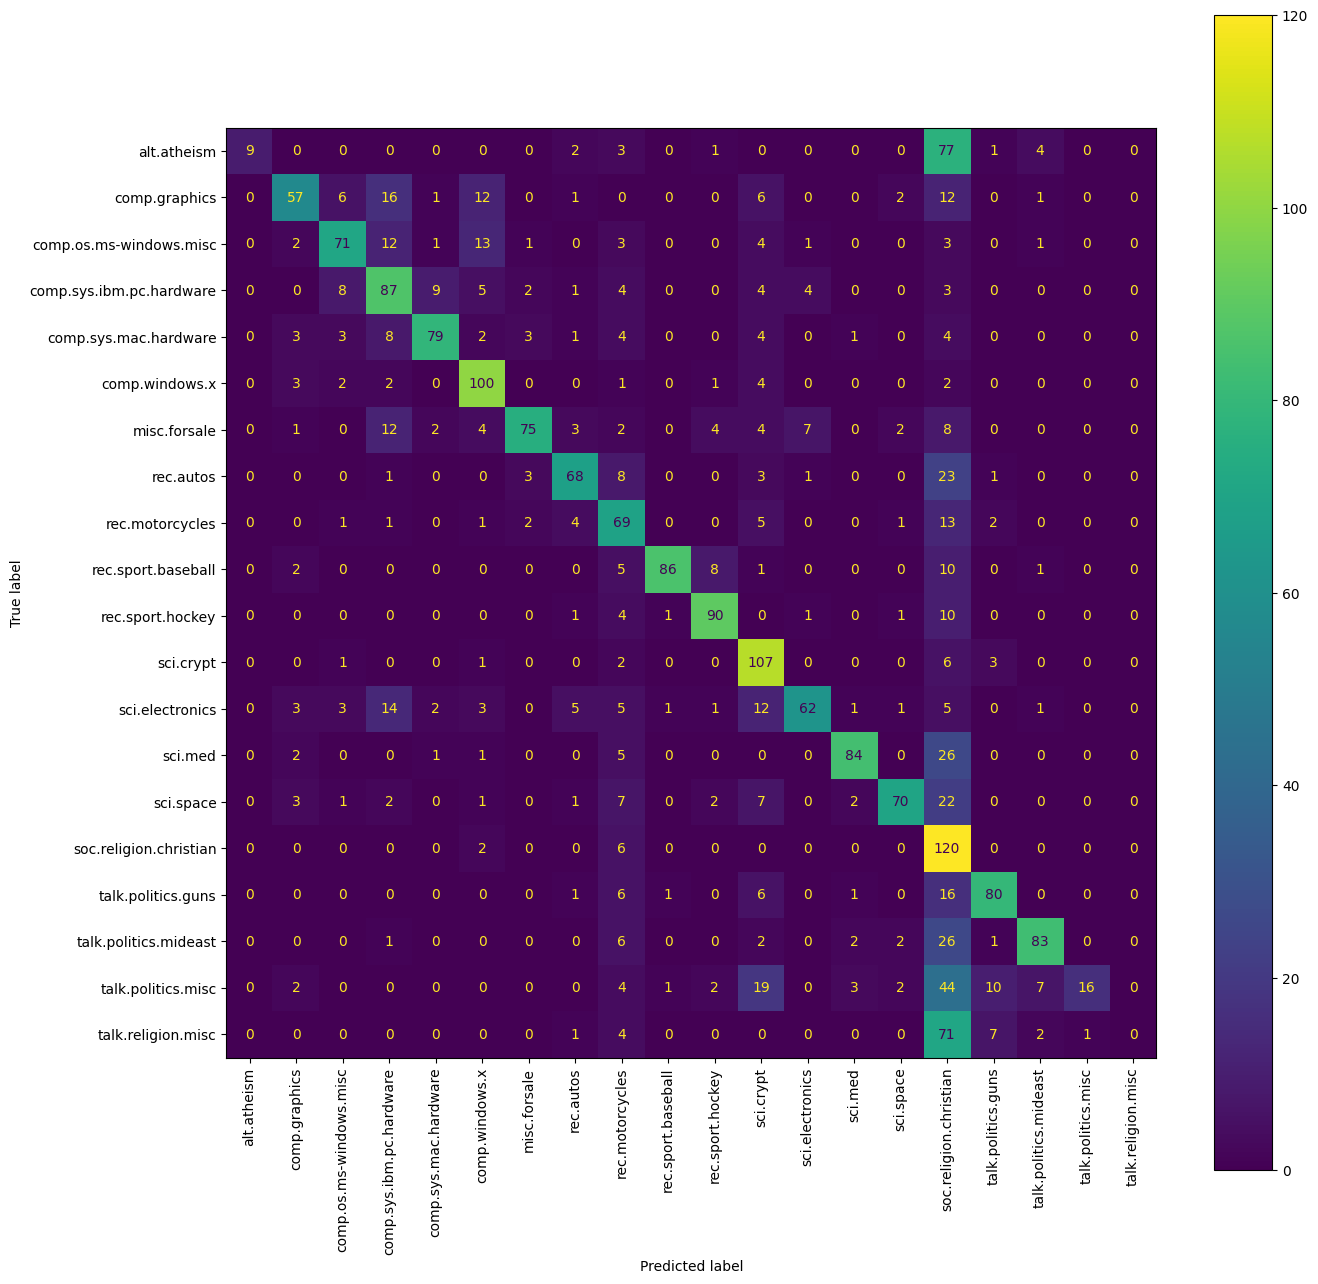

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))

disp = ConfusionMatrixDisplay.from_estimator(
    nb_classifier,
    X_val,
    val_labels,
    ax=ax,
    display_labels=training_corpus.target_names,
    xticks_rotation="vertical",
)

## Classification Report

In [26]:
print(
    metrics.classification_report(
        val_labels, val_preds, target_names=training_corpus.target_names
    )
)

                          precision    recall  f1-score   support

             alt.atheism       1.00      0.09      0.17        97
           comp.graphics       0.73      0.50      0.59       114
 comp.os.ms-windows.misc       0.74      0.63      0.68       112
comp.sys.ibm.pc.hardware       0.56      0.69      0.61       127
   comp.sys.mac.hardware       0.83      0.71      0.76       112
          comp.windows.x       0.69      0.87      0.77       115
            misc.forsale       0.87      0.60      0.71       124
               rec.autos       0.76      0.63      0.69       108
         rec.motorcycles       0.47      0.70      0.56        99
      rec.sport.baseball       0.96      0.76      0.85       113
        rec.sport.hockey       0.83      0.83      0.83       108
               sci.crypt       0.57      0.89      0.69       120
         sci.electronics       0.82      0.52      0.64       119
                 sci.med       0.89      0.71      0.79       119
         

/home/misha/.pyenv/versions/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/misha/.pyenv/versions/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/misha/.pyenv/versions/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

## Выводы по результатам

1. `alt.atheism` имеет высокий `precision` и низкий `recall`, что говорит нам о том, что, если модель относит пост к атеизму, то делает это правильно, но большинство из постов, реально относящихся к атезму, он определяет в `soc.religion.christian`.
2. `talk.religion.misc` - модель ничего не относит к этому классу.
3. Чем различнее темы, тем лучше результат. Например, темы относящиеся к `comp.`, модель хуже классифицирует.


## Улучшение модели

Одна из проблем может быть связана с тем, что наш **словарь во много раз больше обучающей выборки**

In [27]:
print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Число слов в словаре: {len(X_train[0].toarray().flatten())}")

Размер обучающей выборки: 9051
Число слов в словаре: 51637


Можно сократить словарь:
- Убрав стоп слова. Так модель будет лучше учитывать специфичные для темы слова.
- Использовать леммы.

In [28]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tok2vec"])

In [29]:
def spacy_tokenizer(string: str):
    return [t.lemma_ for t in nlp(string) if t.is_alpha and not t.is_stop]

In [30]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, token_pattern=None)
vectorizer.fit(train_data)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function spa...x74338b6231a0>
,analyzer,'word'
,stop_words,None
,token_pattern,None
,ngram_range,"(1, ...)"


In [31]:
X_train = vectorizer.transform(train_data)
X_val = vectorizer.transform(val_data)

In [32]:
print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Число слов в словаре: {len(X_train[0].toarray().flatten())}")

Размер обучающей выборки: 9051
Число слов в словаре: 51338


In [33]:
nb_classifier.fit(X_train, train_labels)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [34]:
train_preds = nb_classifier.predict(X_train)
print(
    f"Train F1-score: {metrics.f1_score(train_labels, train_preds, average='macro')}"
)
print(f"Train Accuracy {metrics.accuracy_score(train_labels, train_preds)}")

Train F1-score: 0.8627282559888032
Train Accuracy 0.880123743232792


In [35]:
val_preds = nb_classifier.predict(X_val)
print(
    f"Train F1-score: {metrics.f1_score(val_labels, val_preds, average='macro')}"
)
print(f"Train Accuracy {metrics.accuracy_score(val_labels, val_preds)}")

Train F1-score: 0.6798856023674228
Train Accuracy 0.7030490499337163


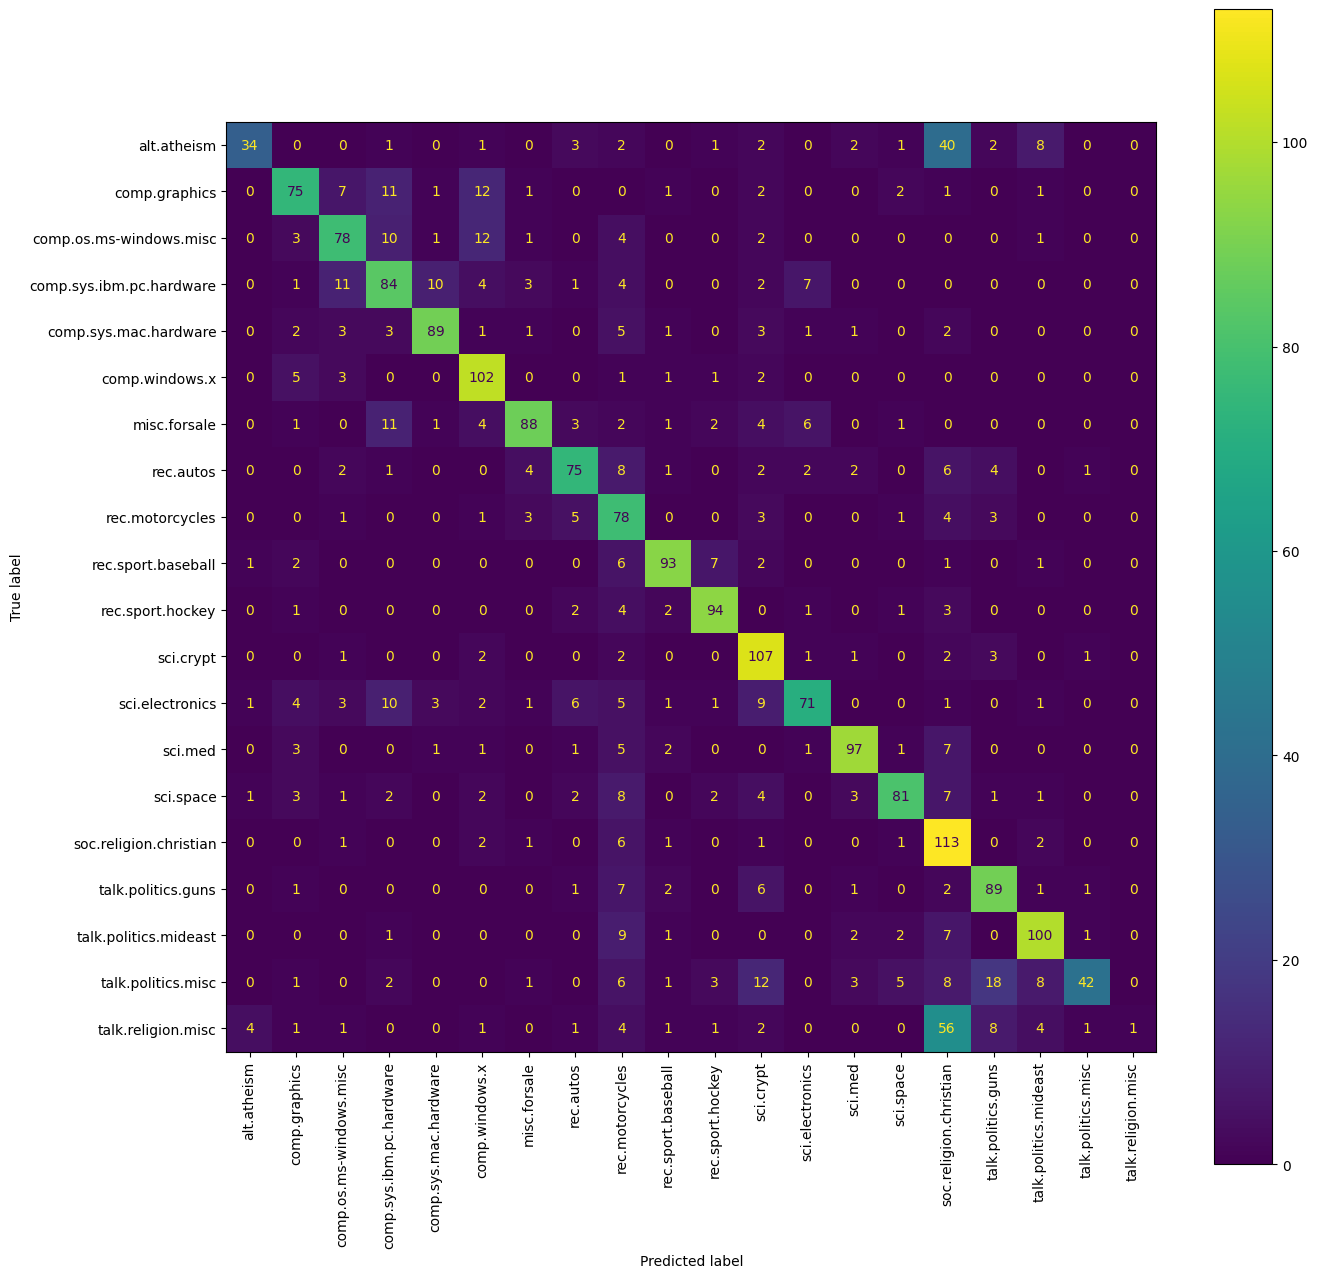

In [36]:
fig, ax = plt.subplots(figsize=(15, 15))

disp = ConfusionMatrixDisplay.from_estimator(
    nb_classifier,
    X_val,
    val_labels,
    ax=ax,
    display_labels=training_corpus.target_names,
    xticks_rotation="vertical",
)

In [37]:
print(
    metrics.classification_report(
        val_labels, val_preds, target_names=training_corpus.target_names
    )
)

                          precision    recall  f1-score   support

             alt.atheism       0.83      0.35      0.49        97
           comp.graphics       0.73      0.66      0.69       114
 comp.os.ms-windows.misc       0.70      0.70      0.70       112
comp.sys.ibm.pc.hardware       0.62      0.66      0.64       127
   comp.sys.mac.hardware       0.84      0.79      0.82       112
          comp.windows.x       0.69      0.89      0.78       115
            misc.forsale       0.85      0.71      0.77       124
               rec.autos       0.75      0.69      0.72       108
         rec.motorcycles       0.47      0.79      0.59        99
      rec.sport.baseball       0.85      0.82      0.84       113
        rec.sport.hockey       0.84      0.87      0.85       108
               sci.crypt       0.65      0.89      0.75       120
         sci.electronics       0.79      0.60      0.68       119
                 sci.med       0.87      0.82      0.84       119
         

Нам удалось повысить качество модели за счет предобработки текстов.

### Перебор гиперпараметров

Параметр $\alpha$ отвечает за сглаживание, грубо говоря, вероятности слова, по условию класса.
- **α = 1 (Сглаживание Лапласа)**: Наиболее распространенный и интуитивно понятный вариант.
- **α < 1 (напр., α = 0.5)**: Иногда используется для более "легкого" сглаживания, если словарь очень большой и нужно сильнее полагаться на наблюдаемые частоты.
- **α > 1**: Усиливает эффект сглаживания, делает модель более радикально "осторожной" по отношению к незнакомым словам. На практике используется реже.

In [38]:
# The alpha values to try.
params = {
    "alpha": [
        0.01,
        0.1,
        0.5,
        1.0,
        10.0,
    ],
}

multinomial_nb_grid = model_selection.GridSearchCV(
    MultinomialNB(),
    param_grid=params,
    scoring="f1_macro",
    n_jobs=-1,
    cv=5,
    verbose=5,
)
multinomial_nb_grid.fit(X_train, train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 5/5] END .........................alpha=0.1;, score=0.749 total time=   0.1s
[CV 2/5] END .........................alpha=0.5;, score=0.697 total time=   0.1s
[CV 1/5] END .........................alpha=0.1;, score=0.725 total time=   0.1s
[CV 3/5] END ........................alpha=0.01;, score=0.727 total time=   0.1s
[CV 3/5] END .........................alpha=0.5;, score=0.682 total time=   0.1s
[CV 5/5] END ........................alpha=0.01;, score=0.766 total time=   0.1s
[CV 1/5] END ........................alpha=0.01;, score=0.734 total time=   0.1s
[CV 2/5] END .........................alpha=1.0;, score=0.684 total time=   0.1s
[CV 4/5] END .........................alpha=0.1;, score=0.735 total time=   0.1s
[CV 1/5] END .........................alpha=0.5;, score=0.698 total time=   0.1s
[CV 3/5] END .........................alpha=1.0;, score=0.667 total time=   0.1s
[CV 4/5] END .........................alpha=1.0;,

,estimator,MultinomialNB()
,param_grid,"{'alpha': [0.01, 0.1, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,5
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.01


In [39]:
print(f"Лучшая модель с параметрами: {multinomial_nb_grid.best_params_}")

Лучшая модель с параметрами: {'alpha': 0.01}


In [40]:
val_preds = multinomial_nb_grid.predict(X_val)
print(
    f"Train F1-score: {metrics.f1_score(val_labels, val_preds, average='macro')}"
)
print(f"Train Accuracy {metrics.accuracy_score(val_labels, val_preds)}")

Train F1-score: 0.7329624829942916
Train Accuracy 0.7401679186920017


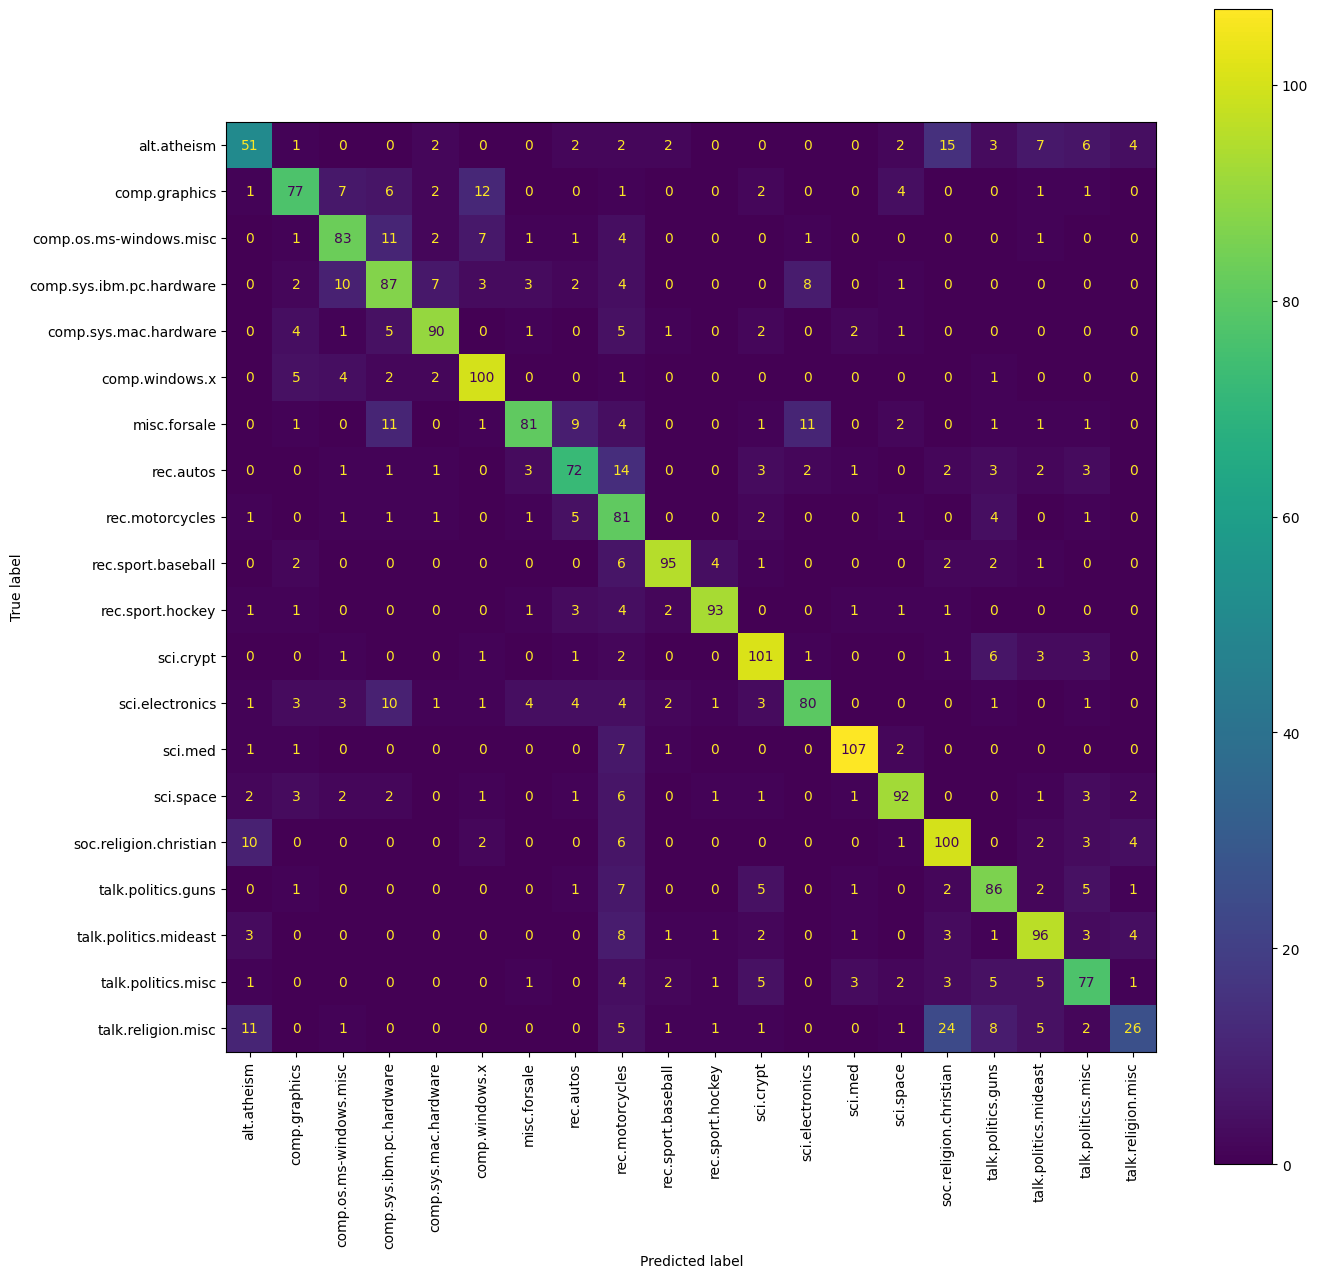

In [41]:
fig, ax = plt.subplots(figsize=(15, 15))

disp = ConfusionMatrixDisplay.from_estimator(
    multinomial_nb_grid,
    X_val,
    val_labels,
    ax=ax,
    display_labels=training_corpus.target_names,
    xticks_rotation="vertical",
)

In [42]:
print(
    metrics.classification_report(
        val_labels, val_preds, target_names=training_corpus.target_names
    )
)

                          precision    recall  f1-score   support

             alt.atheism       0.61      0.53      0.57        97
           comp.graphics       0.75      0.68      0.71       114
 comp.os.ms-windows.misc       0.73      0.74      0.73       112
comp.sys.ibm.pc.hardware       0.64      0.69      0.66       127
   comp.sys.mac.hardware       0.83      0.80      0.82       112
          comp.windows.x       0.78      0.87      0.82       115
            misc.forsale       0.84      0.65      0.74       124
               rec.autos       0.71      0.67      0.69       108
         rec.motorcycles       0.46      0.82      0.59        99
      rec.sport.baseball       0.89      0.84      0.86       113
        rec.sport.hockey       0.91      0.86      0.89       108
               sci.crypt       0.78      0.84      0.81       120
         sci.electronics       0.78      0.67      0.72       119
                 sci.med       0.91      0.90      0.91       119
         

## Выводы по улучшению модели

Нам удалось увеличить `F1-score` с `0.609` до `0.732`. Это большой успех.

Картина с `alt.atheism` и `religion.misc` стала лучше, но все еще остаются ошибки.

С таким маленьким набором данных у нас уже хороший результат. Но есть еще идеи:

- Дополнить данные.
- Включить `n-grams`.
- Если бизнес задача позволяет, можно удалить категории `misc` и объединить сильно пересекающиеся темы.
- Добавить больше стоп слов, для их исключения.
- Перебрать `min_df`, `max_df` и `max_features` в векторизаторе `TF-IDF`.
- Попробовать другие модели: логистическую регрессию, метод опорных векторов, случайные леса и т.д.

## Тестирование модели

In [43]:
text_classifier = Pipeline(
    [
        (
            "vectorizer",
            TfidfVectorizer(tokenizer=spacy_tokenizer, token_pattern=None),
        ),
        ("classifier", MultinomialNB(alpha=0.01)),
    ]
)

In [44]:
text_classifier.fit(training_corpus.data, training_corpus.target)

,steps,"[('vectorizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function spa...x74338b6231a0>


In [45]:
test_corpus = fetch_20newsgroups(
    subset="test", remove=("headers", "footers", "quotes")
)

In [46]:
test_preds = text_classifier.predict(test_corpus.data)

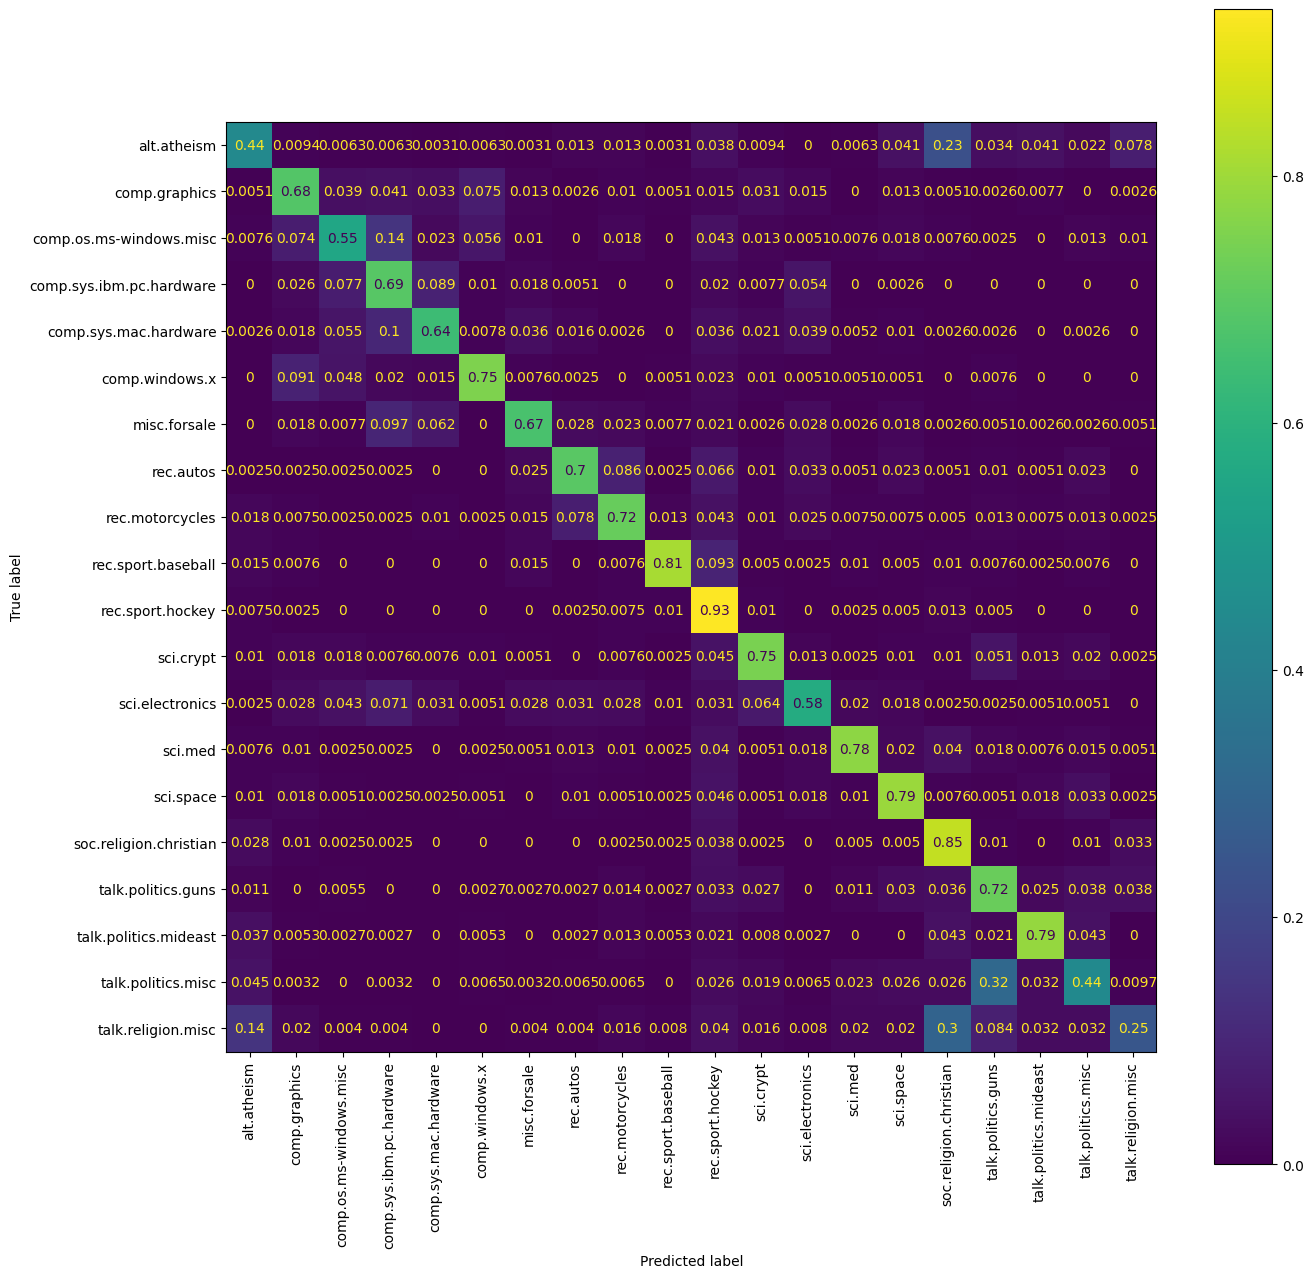

In [47]:
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    test_corpus.target,
    test_preds,
    normalize="true",
    display_labels=test_corpus.target_names,
    xticks_rotation="vertical",
    ax=ax,
)
plt.show()

In [48]:
print(
    metrics.classification_report(
        test_corpus.target,
        test_preds,
        target_names=test_corpus.target_names,
    )
)

                          precision    recall  f1-score   support

             alt.atheism       0.55      0.44      0.49       319
           comp.graphics       0.65      0.68      0.67       389
 comp.os.ms-windows.misc       0.64      0.55      0.59       394
comp.sys.ibm.pc.hardware       0.58      0.69      0.63       392
   comp.sys.mac.hardware       0.70      0.64      0.67       385
          comp.windows.x       0.80      0.75      0.78       395
            misc.forsale       0.78      0.67      0.72       390
               rec.autos       0.77      0.70      0.73       396
         rec.motorcycles       0.74      0.72      0.73       398
      rec.sport.baseball       0.91      0.81      0.86       397
        rec.sport.hockey       0.58      0.93      0.72       399
               sci.crypt       0.74      0.75      0.74       396
         sci.electronics       0.68      0.58      0.62       393
                 sci.med       0.86      0.78      0.81       396
         

## Использование модели

Следующая функция возвращает предсказание модели и его оценку вероятности.

Можно добавить порог принятие предсказания. В случае, если вероятность ниже этого порога, пост можно отправить на оценку человеком.

Также можно установить минимальную длину текста для предсказания.

In [49]:
def classify_text(clf, doc, labels=None):
    """Возвращает предсказание и его вероятность"""
    probas = clf.predict_proba([doc]).flatten()
    max_proba_idx = np.argmax(probas)

    if labels:
        most_proba_class = labels[max_proba_idx]
    else:
        most_proba_class = max_proba_idx

    return (most_proba_class, probas[max_proba_idx])

In [50]:
# Post from r/medicine.
s = "Hello everyone so am doing my thesis on Ischemic heart disease have been using online articles and textbooks mostly Harrisons internal med. could u recommended me some source specifically books where i can get more about in depth knowledge on IHD."
classify_text(text_classifier, s, test_corpus.target_names)

('sci.med', 0.45341575624707914)

In [51]:
# Post from r/space.
s = "First evidence that water can be created on the lunar surface by Earth's magnetosphere. Particles from Earth can seed the moon with water, implying that other planets could also contribute water to their satellites."
classify_text(text_classifier, s, test_corpus.target_names)

('sci.space', 0.9843674733350941)

In [52]:
# Post from r/cars.
s = "New Toyota 86 Launch Reportedly Delayed to 2022, CEO Doesn't Want a Subaru Copy"
classify_text(text_classifier, s, test_corpus.target_names)

('rec.autos', 0.8279998023415086)

In [53]:
# Post from r/electronics.
s = "My First Ever Homemade PCB. My SMD Soldering Skills Aren't Great, But I'm Quite Proud of it."
classify_text(text_classifier, s, test_corpus.target_names)

('sci.electronics', 0.8329410621099287)

Дальше примеры с маленькой вероятностью

In [54]:
s = "I don't know if that's a good idea."
classify_text(text_classifier, s, test_corpus.target_names)

('soc.religion.christian', 0.08308211799646249)

In [55]:
s = "Hold on for dear life."
classify_text(text_classifier, s, test_corpus.target_names)

('soc.religion.christian', 0.26924646512362593)